## Bayesian Approach to Modelling Systolic Blood Pressure

In [ ]:
import arviz as az
import numpy as np
import pymc as pm
import scipy.stats as ss

We observe systolic blood pressure (SBP) values (in mmHg) for **n = 30** patients:

```python
[128, 142, 135, 150, 131, 138, 129, 144, 155, 120,
134, 137, 141, 133, 147, 130, 139, 136, 132, 148,
125, 143, 149, 126, 140, 145, 127, 158, 122, 137]
```

We model each measurement as normally distributed:

$$
y_i \sim \mathcal{N}(\mu, \sigma^2), \quad i = 1,\ldots,n
$$

where:
- $\mu$ = population mean SBP
-  $\sigma^2$  = population variance

---

### **Scenario A: Known Variance**
Assume population/measurement standard deviation is known:

$$
\sigma = 15 \text{ mmHg}
$$

Use a conjugate **Normal prior** for the mean:

$$
\mu \sim \mathcal{N}(\mu_0 = 130,\ \tau_0^2 = 10^2)
$$

---

### **Scenario B: Unknown Variance (Normal–Inverse-Gamma Prior)**

Joint prior:

$$
\mu \mid \sigma^2 \sim \mathcal{N}\left(\mu_0 = 130,\ \frac{\sigma^2}{\kappa_0} \right), \quad \kappa_0 = 1
$$

$$
\sigma^2 \sim \text{Inverse-Gamma}(\alpha_0 = 3,\ \beta_0 = 300)
$$

This is a conjugate prior, so the posterior will also be Normal–Inverse-Gamma.

---

## Questions to Work Through





### 5. Model Checking and Sensitivity

1. Perform posterior predictive checks (PPCs):
   - Compare observed vs predictive distributions.
   - Include a graphical comparison.

2. Perform prior sensitivity checks:
   - Re-run under:
     - $\mu \sim \mathcal{N}(120, 20^2)$
     - $\mu \sim \mathcal{N}(135, 5^2)$
   - Report how posterior conclusions change.

3. Extend to a **two-clinic hierarchical model**:
   - Write a model allowing each clinic to have its own mean $\mu_j$.
   - Specify priors and sketch how you would fit it.


### 1. Posterior (Known Variance — Analytical)

Using **Scenario A** (known $\sigma = 15$):

1. Write down the likelihood and the Normal prior for $\mu$.
2. Derive the posterior distribution $p(\mu \mid \mathbf{y})$ in closed form.
3. Compute the posterior mean, posterior variance, and a 95% credible interval for $\mu$ using the given data.

If we have:
$$
\mu \sim N \left( \mu_0, \tau_0^2 \right)
$$
and 
$$
y_i \sim N \left( \mu, \sigma^2 \right)
$$

Then the posterior distribution is $\mu | \{ y_i \}_{i=0}^{n} = N \left( \mu_n, \sigma_n^2 \right)$ where:
$$
\begin{aligned}
\mu_n &= \frac{1}{\frac{1}{\tau_0^2} + \frac{n}{\sigma^2}} \left( \frac{\mu_0}{\tau_0^2} + \frac{n \cdot \bar{y}}{\sigma^2} \right) \\
\sigma_n^2 &= \frac{1}{\frac{1}{\tau_0^2} + \frac{n}{\sigma^2}}
\end{aligned}
$$

In [10]:
sample = [
    128,
    142,
    135,
    150,
    131,
    138,
    129,
    144,
    155,
    120,
    134,
    137,
    141,
    133,
    147,
    130,
    139,
    136,
    132,
    148,
    125,
    143,
    149,
    126,
    140,
    145,
    127,
    158,
    122,
    137,
]

empirical_mean = np.mean(sample)
sigma = 15
tau_0 = 10
n = 30
mu_0 = 130

posterior_variance = 1 / ((1 / tau_0) ** 2 + n * (1 / sigma) ** 2)
posterior_mean = posterior_variance * (
    mu_0 / (tau_0**2) + (n * empirical_mean) / (sigma**2)
)

print(
    f"Posterior mean = {posterior_mean:.3f}; "
    f"posterior variance = {posterior_variance:.3f}"
)

Posterior mean = 136.853; posterior variance = 6.977


In [ ]:
posterior_distribution = ss.norm(loc=posterior_mean, scale=np.sqrt(posterior_variance))

q2_5, q97_5 = posterior_distribution.ppf([0.025, 0.975])

print(f"The 95% credible interval for the posterior mean is: ({q2_5:.3f}, {q97_5:.3f})")

The 95% credible interval for the posterior mean is: (131.676, 142.030)


### 2. Posterior (Unknown Variance — Analytical Conjugate)

Using **Scenario B** (Normal–Inverse-Gamma):

1. Write the joint prior $p(\mu, \sigma^2)$ and the likelihood.
2. Derive the updated posterior hyperparameters $(\kappa_n, \mu_n, \alpha_n, \beta_n)$.
3. Using the data, compute:
   - Posterior mean of $\mu$
   - Posterior mean of $\sigma^2$
   - 95% credible intervals for both.

In [ ]:
alpha_0 = 3
beta_0 = 300
mu_0 = 130
kappa_0 = 1

alpha_n = alpha_0
beta_n = beta_0 + kappa_0 * (mu_0**2)
kappa_n = 2 * (kappa_0 + n)
mu_n = (2 * kappa_0 * mu_0 + n * empirical_mean) / kappa_n

In [ ]:
posterior_mu_mean = mu_n
posterior_sigma_mean = beta_n / (alpha_n - 1)

print(
    f"Posterior mean for mu: {posterior_mu_mean:.3f}; sigma: {posterior_sigma_mean:.3f}"
)

Posterior mean for mu: 70.661; sigma: 8600.000



### 3. Python Computation (Analytical + Sampling)

1. **Scenario A:**  
   - Compute the posterior analytically in Python.
   - Plot prior vs posterior density for $\mu$.
   - Report posterior mean and 95% credible interval.

2. **Scenario B:**  
   - Draw samples from the Normal–Inverse-Gamma posterior directly.
   - Fit the same model in an MCMC framework (e.g., PyMC or NumPyro).
   - Compare posterior summaries and show trace/diagnostic plots.

3. Compute and plot the **posterior predictive distribution** for a new patient’s SBP under Scenario B, and compute:
   $$
   P(\text{new SBP} > 140 \mid \mathbf{y})
   $$


In [46]:
# scenario A
with pm.Model() as model_a:
    mu = pm.Normal(name="mu", mu=130, sigma=10)
    y = pm.Normal(name="blood_pressure", mu=mu, sigma=15, observed=sample)

    trace_a = pm.sample(draw=3000, tune=1000, chains=4)
    posterior_predictive_a = pm.sample_posterior_predictive(trace_a)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [blood_pressure]


Output()

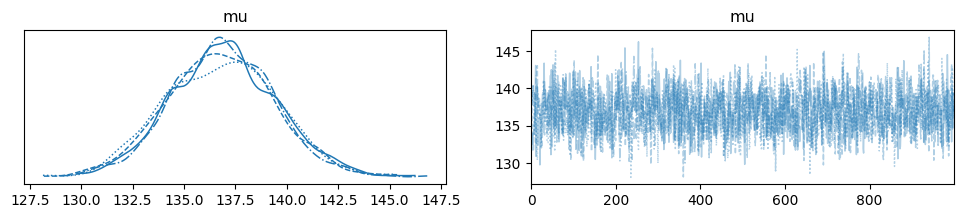

In [27]:
az.plot_trace(trace_a)

plt.show()

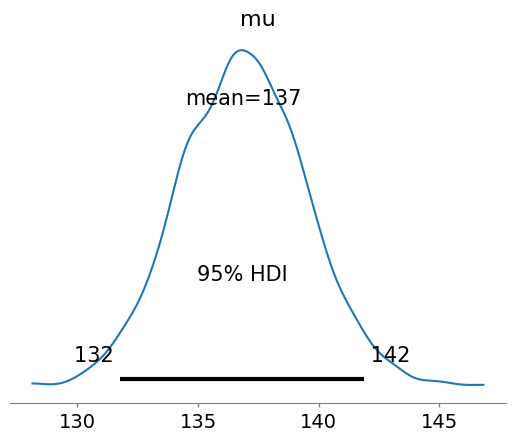

In [30]:
az.plot_posterior(trace_a, hdi_prob=0.95)
plt.show()

In [36]:
# scenario B
with pm.Model() as model_b:
    sig = pm.InverseGamma("sigma", alpha=3, beta=300)
    mu = pm.Normal(name="mu", mu=130, sigma=sig / kappa_0)
    y = pm.Normal(name="blood_pressure", mu=mu, sigma=sig, observed=sample)

    trace_b = pm.sample(draw=3000, tune=1000, chains=4)
    posterior_predictive_b = pm.sample_posterior_predictive(trace=trace_b)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [blood_pressure]


Output()

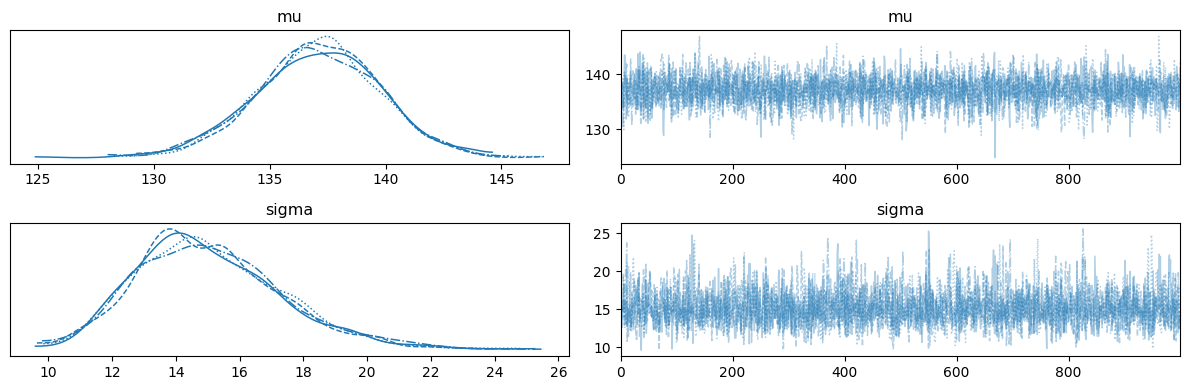

In [33]:
az.plot_trace(trace_b)
plt.tight_layout()
plt.show()

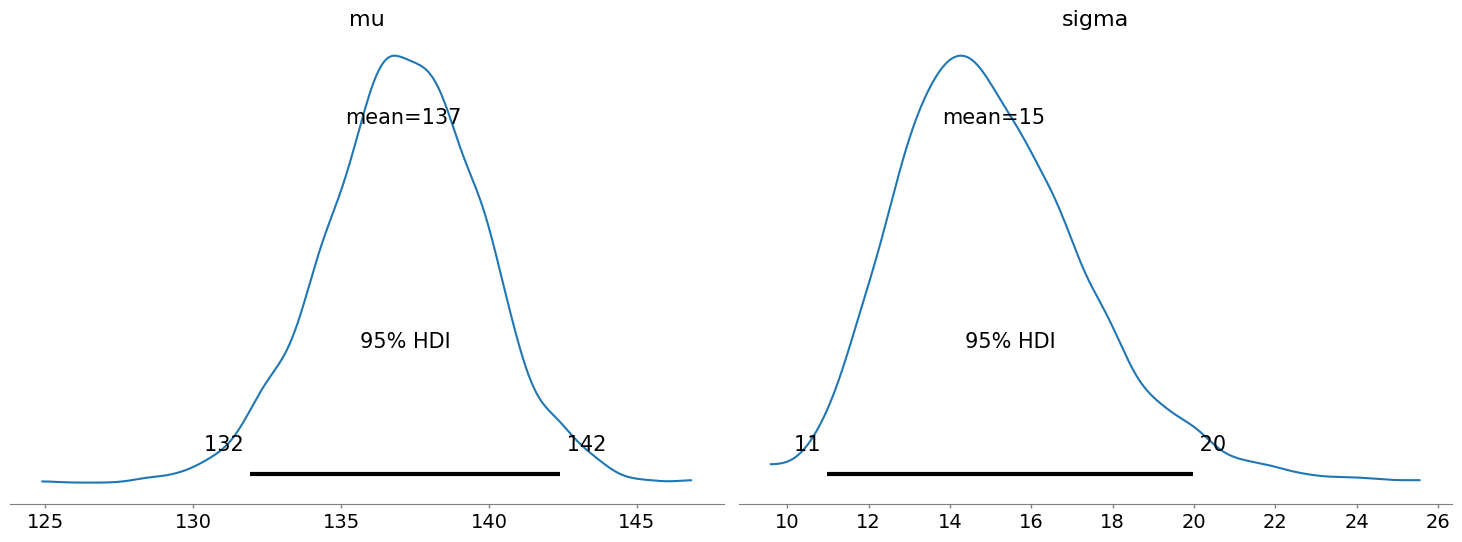

In [ ]:
az.plot_posterior(trace_b, hdi_prob=0.95)
plt.tight_layout()
plt.show()

In [47]:
(posterior_predictive_a["posterior_predictive"]["blood_pressure"] >= 140).mean()

<xarray.DataArray 'blood_pressure' ()> Size: 8B
array(0.41860833)

In [ ]:
(posterior_predictive_b["posterior_predictive"]["blood_pressure"] >= 140).mean()

<xarray.DataArray 'blood_pressure' ()> Size: 8B
array(0.42756667)



### 4. Bayesian Hypothesis Statements

1. Compute $P(\mu > 140 \mid \mathbf{y})$ under **both** Scenario A and Scenario B.
2. Under **Scenario A**, compute a Bayes factor comparing:
   - $H_0: \mu = 140$
   - $H_1: \mu \sim \mathcal{N}(130, 10^2)$
3. Compute the posterior probability that $\mu$ lies within the ROPE:
   $$
   \text{ROPE} = [135, 145]
   $$
   Interpret results in terms of practical significance.


In [57]:
# H0
h0_sampling_distribution = ss.norm(loc=140, scale=15 / np.sqrt(n))
values = h0_sampling_distribution.rvs(size=10_000)

h0_prob = (values <= empirical_mean).mean().item()
h0_prob

0.1676

In [ ]:
# H1
mu_dist = ss.norm(loc=130, scale=10)
mu_values = mu_dist.rvs(size=10_000)
h1_sampling_distribution = ss.norm(loc=mu_values, scale=15 / np.sqrt(n))
values = h1_sampling_distribution.rvs()

h1_prob = (values <= empirical_mean).mean().item()
h1_prob

0.7599

In [60]:
h0_prob / h1_prob

0.2205553362284511

In [61]:
h1_prob / h0_prob

4.534009546539379

In [ ]:
posterior_mu_a = trace_a.posterior["mu"].values.flatten()
((135 <= posterior_mu_a) & (posterior_mu_a <= 145)).mean()

np.float64(0.75075)

In [67]:
posterior_mu_b = trace_b.posterior["mu"].values.flatten()
((135 <= posterior_mu_b) & (posterior_mu_b <= 145)).mean()

np.float64(0.802)